In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

In [2]:
SEP = os.sep
ROOT = os.getcwd()  # 练习1项目的根路径

ori_imgs_path = f'{ROOT}{SEP}images{SEP}original'  # 原始图像路径
output_imgs_path = f'{ROOT}{SEP}images{SEP}output'  # 拼接图像输出路径

In [3]:
imgs = []
ori_imgs_path_list = sorted(os.listdir(str(ori_imgs_path)))

for i, img_path in enumerate(ori_imgs_path_list):
    img = cv2.imread(ori_imgs_path + SEP + img_path)
    imgs.append(img)

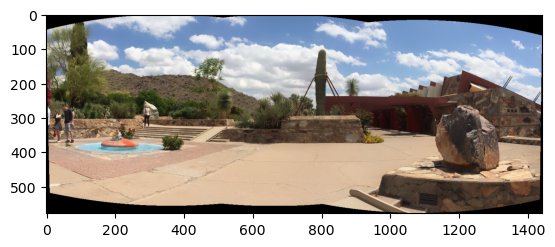

In [4]:
# 拼接
stitcher = cv2.Stitcher_create()
_, stitched = stitcher.stitch(imgs)

plt.imshow(stitched[:,:,::-1])

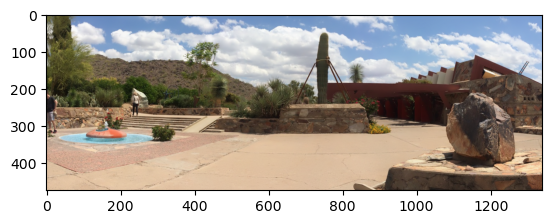

In [5]:
# 裁剪出拼接图片的最大矩形，即去除空白像素点（通过阈值筛选）

# 设置拼接的图片框
stitched = cv2.copyMakeBorder(stitched, 2, 2, 2, 2, cv2.BORDER_CONSTANT, (0, 0, 0))

#将缝合的图像转换为灰度并设置阈值，使得所有大于零的像素都设置为255（前景），而所有其他保持为0（背景）
gray = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

#找到阈值图像中的所有外部轮廓，然后找到最大轮廓
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# 生成一个拼图片的Mask
mask = np.zeros(thresh.shape, dtype="uint8")
(x, y, w, h) = cv2.boundingRect(c)
cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

# 创建掩码的两个副本：一个用作实际的最小矩形区域，另一个用作计数器，用于计算需要移除多少像素才能形成最小矩形区域
minRect = mask.copy()
sub = mask.copy()

# 保持循环，直到中没有非零像素为止
while cv2.countNonZero(sub) > 0:
    minRect = cv2.erode(minRect, None)  # 侵蚀最小矩形遮罩，减去最小矩形掩模的阈值图像
    sub = cv2.subtract(minRect, thresh)

# 在最小矩形Mask中找到轮廓，然后提取边界框（x，y）-坐标
cnts = cv2.findContours(minRect.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
(x, y, w, h) = cv2.boundingRect(c)

# 将拼接图像提取到框中，并切换cv2图片格式BGR为RGB
stitched = stitched[y:(y + h), x:(x + w)][:,:,::-1]

cv2.imwrite(f"{output_imgs_path}{SEP}output.jpg", stitched)
plt.imshow(stitched)